pip install git+https://github.com/coreylynch/pyFM -->
pip command to install the package

In [1]:
## google colab command for installing the package --> !pip install git+https://github.com/coreylynch/pyFM
#pip install git+https://github.com/coreylynch/pyFM

  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-3cdoo7yq
  Running command git clone -q https://github.com/coreylynch/pyFM /tmp/pip-req-build-3cdoo7yq
  Created wheel for pyfm: filename=pyfm-0.0.0-cp36-cp36m-linux_x86_64.whl size=220620 sha256=80f7f03529aeedd2dbbdc19ab40e5edd1a44aecbb552f3273d79edd0ebe5dc4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d3ezx2d/wheels/3b/d9/ef/1b148c527d39344632833679e79b3db1798a40b0f64f917b13
Successfully built pyfm


In [0]:
import numpy as np
import pandas as pd
import scipy as sp
import json
from sklearn.feature_extraction import DictVectorizer
from pyfm import pylibfm
from sklearn.preprocessing import normalize
from scipy import sparse
from io import StringIO  # Python3
import sys
from sklearn.metrics import mean_squared_error
import math  

In [4]:
## Train and test datasets
dataset = pd.read_csv("../data/merged_data.csv")
test_dataset = dataset[dataset.groupby('user_id')['date'].transform('max') == dataset['date']]
print("test dataset created")
train_dataset = pd.concat([dataset, test_dataset, test_dataset]).drop_duplicates(keep=False)
print("train dataset created")

test dataset created
train dataset created


In [0]:
## Forming y (predictions columns)
y_train = train_dataset[['rating']].to_numpy()
y_train = np.squeeze(y_train)

y_test = test_dataset[['rating']].to_numpy()
y_test = np.squeeze(y_test)

In [0]:
## Forming X 
# no metadata
x_train_nometa = (train_dataset[['user_id', 'business_id']]).to_dict('records')
x_test_nometa = (test_dataset[['user_id', 'business_id']]).to_dict('records')

# only item metadata
x_train_itemmeta = (train_dataset[['user_id', 'business_id', 'avg_rating', 'review_cnt_x', 'latitude', 'longitude', 'is_open', 'RestaurantsPriceRange2']]).to_dict('records')
x_train_meta_itemmeta = (train_dataset.iloc[:, list(range(34, 499))+list(range(500, 510))]) #499 is 'RestaurantsPriceRange2', 509 last entry
x_test_itemmeta = (test_dataset[['user_id', 'business_id', 'review_cnt_x', 'latitude', 'longitude', 'is_open', 'RestaurantsPriceRange2']]).to_dict('records')
x_test_meta_itemmeta = (test_dataset.iloc[:, list(range(34, 499))+list(range(500, 510))])

# only user metadata
x_train_usermeta = (train_dataset.iloc[:, [2, 3, 15]+list(range(17, 22))+list(range(23, 34))]).to_dict('records')
x_test_usermeta = (test_dataset.iloc[:, [2, 3, 15]+list(range(17, 22))+list(range(23, 34))]).to_dict('records')

# all metadata
x_train_allmeta = (train_dataset.iloc[:, [2, 3, 8, 9, 11, 12, 13, 15, 499]+list(range(17, 22))+list(range(23, 34))]).to_dict('records')
x_train_meta_allmeta = (train_dataset.iloc[:, list(range(34, 499))+list(range(500, 510))])
x_test_allmeta = (test_dataset.iloc[:, [2, 3, 8, 9, 11, 12, 13, 15, 499]+list(range(17, 22))+list(range(23, 34))]).to_dict('records')
x_test_meta_allmeta = (test_dataset.iloc[:, list(range(34, 499))+list(range(500, 510))])


In [0]:
## plot code
import matplotlib.pyplot as plt
def draw_compare_plot(dictionary_list, label_line_list, title, xlabel, ylabel, file_tag, figure_number):
    f = plt.figure(figure_number)
    for entry, lab in zip(dictionary_list, label_line_list):
        plt.plot(list(entry.keys()), list(entry.values()), label = lab)
    plt.xscale('log')
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig('../output/rmse_vs_'+ file_tag +'_plot.png')

In [0]:
## the main FM function
def run_fm(x_train, x_test, x_meta_train, x_meta_test, y_train, y_test):
    v = DictVectorizer()
    X_train = v.fit_transform(x_train)
    X_test = v.transform(x_test)

    if type(x_meta_train) == int:
        X_test_final = sp.sparse.hstack([X_test])
        X_train_final = sp.sparse.hstack([X_train])
    else:
        x_meta_train = x_meta_train.to_numpy()
        x_meta_train = sp.sparse.csr_matrix(x_meta_train)

        x_meta_test = x_meta_test.to_numpy()
        x_meta_test = sp.sparse.csr_matrix(x_meta_test)

        X_test_final = sp.sparse.hstack([X_test, x_meta_test])
        X_train_final = sp.sparse.hstack([X_train, x_meta_train])

    # hyperparameter: validation set
    set_validation_size = [0.01, 0.05, 0.10, 0.25] # 4 values 
    dict_validation_set = {}
    rmse_valset = {}
    for value1 in set_validation_size:
        old_stdout = sys.stdout
        result = StringIO()
        sys.stdout = result
        #do_fancy_stuff()
        fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal", validation_size=value1)
        fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)
        #-----
        sys.stdout = old_stdout
        result_string = result.getvalue()
        dict_validation_set[value1] = math.sqrt(float(result_string[-8:-1]))
        # evaluate
        preds = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
        rmse_valset[value1] = math.sqrt(mean_squared_error(y_test,preds))

    #hyperparameter: initial learning rate
    set_initial_learning_rate = [0.005, 0.01, 0.05, 0.10] # 4 values
    dict_initial_learning_rate = {}
    rmse_initialset = {}
    for value2 in set_initial_learning_rate:
        old_stdout = sys.stdout
        result = StringIO()
        sys.stdout = result
        #do_fancy_stuff()
        fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal", validation_size=0.01, initial_learning_rate = value2)
        fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)
        #-----
        sys.stdout = old_stdout
        result_string = result.getvalue()
        try:
            dict_initial_learning_rate[value2] = math.sqrt(float(result_string[-8:-1]))
        except:
            dict_initial_learning_rate[value2] = 'nan'
        # evaluate
        preds = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
        rmse_initialset[value2] = math.sqrt(mean_squared_error(y_test,preds))

    #hyperparameter: num factors
    set_num_factors = [10, 50, 100] # 3 values 
    dict_num_factors = {}
    rmse_num_factors = {}
    for value3 in set_num_factors:
        old_stdout = sys.stdout
        result = StringIO()
        sys.stdout = result
        #do_fancy_stuff()
        fm = pylibfm.FM(num_iter=value3, task="regression", learning_rate_schedule="optimal", validation_size=0.01, initial_learning_rate = 0.01)
        fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)
        #-----
        sys.stdout = old_stdout
        result_string = result.getvalue()
        try:
            dict_num_factors[value3] = math.sqrt(float(result_string[-8:-1]))
        except:
            dict_num_factors[value3] = 'nan'
        # evaluate
        preds = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
        rmse_num_factors[value3] = math.sqrt(mean_squared_error(y_test,preds))

    return dict_validation_set, dict_initial_learning_rate, dict_num_factors, rmse_valset, rmse_initialset, rmse_num_factors

In [0]:
# fm function calls # no metadata
dict_validation_set_nometa, dict_initial_learning_rate_nometa, dict_num_factors_nometa, rmse_valset_nometa, rmse_initialset_nometa, rmse_num_factors_nometa = run_fm(x_train_nometa, x_test_nometa, 0, 0, y_train, y_test)

In [0]:
# item metadata
dict_validation_set_itemmeta, dict_initial_learning_rate_itemmeta, dict_num_factors_itemmeta, rmse_valset_itemmeta, rmse_initialset_itemmeta, rmse_num_factors_itemmeta = run_fm(x_train_itemmeta, x_test_itemmeta, x_train_meta_itemmeta, x_test_meta_itemmeta, y_train, y_test)

In [0]:
# user metadata
dict_validation_set_usermeta, dict_initial_learning_rate_usermeta, dict_num_factors_usermeta, rmse_valset_usermeta, rmse_initialset_usermeta, rmse_num_factors_usermeta = run_fm(x_train_usermeta, x_test_usermeta, 0, 0, y_train, y_test)

In [0]:
# all metadata
dict_validation_set_allmeta, dict_initial_learning_rate_allmeta, dict_num_factors_allmeta, rmse_valset_allmeta, rmse_initialset_allmeta, rmse_num_factors_allmeta = run_fm(x_train_allmeta, x_test_allmeta, x_train_meta_allmeta, x_test_meta_allmeta, y_train, y_test)

In [0]:
## storing the rmse values as json files
rmse_valset_overall = [rmse_valset_nometa, rmse_valset_itemmeta, rmse_valset_usermeta, rmse_valset_allmeta]
rmse_initialset_overall = [rmse_initialset_nometa, rmse_initialset_itemmeta, rmse_initialset_usermeta, rmse_initialset_allmeta]
rmse_num_factors_overall = [rmse_num_factors_nometa, rmse_num_factors_itemmeta, rmse_num_factors_usermeta, rmse_num_factors_allmeta]
with open('../output/rmse_valset_overall', 'w') as fout:
    json.dump(rmse_valset_overall, fout)
with open('../output/rmse_initialset_overall', 'w') as fout:
    json.dump(rmse_initialset_overall, fout)
with open('../output/rmse_num_factors_overall', 'w') as fout:
    json.dump(rmse_num_factors_overall, fout)

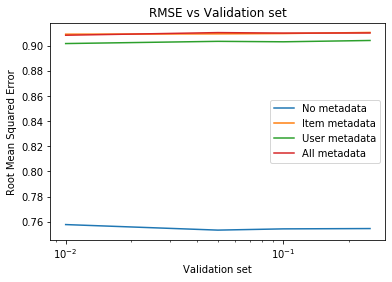

In [0]:
## plot 1 - validation set
dict_validation_set_list = [dict_validation_set_nometa, dict_validation_set_itemmeta,  dict_validation_set_usermeta, dict_validation_set_allmeta]
label_list = ['No metadata', 'Item metadata', 'User metadata', 'All metadata']
draw_compare_plot(dict_validation_set_list, label_list, 'RMSE vs Validation set', 'Validation set', 'Root Mean Squared Error', 'validation_set', 1) #comparison plot
with open('../output/dict_validation_set_list', 'w') as fout:
    json.dump(dict_validation_set_list, fout)

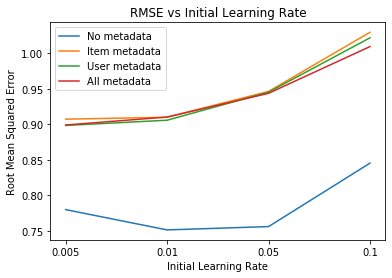

In [12]:
## plot 2 - Initial Learning Rate
dict_initial_learning_rate_list = [dict_initial_learning_rate_nometa, dict_initial_learning_rate_itemmeta,  dict_initial_learning_rate_usermeta, dict_initial_learning_rate_allmeta]
label_list2 = ['No metadata', 'Item metadata', 'User metadata', 'All metadata']
draw_compare_plot(dict_initial_learning_rate_list, label_list2, 'RMSE vs Initial Learning Rate', 'Initial Learning Rate', 'Root Mean Squared Error', 'initial_learning_rate', 2) #comparison plot
with open('../output/dict_initial_learning_rate_list', 'w') as fout:
    json.dump(dict_initial_learning_rate_list, fout)

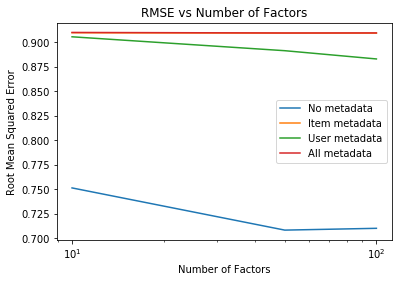

In [0]:
## plot 3 - Number of factors (Number of latent dimensions)
dict_num_factors_list = [dict_num_factors_nometa, dict_num_factors_itemmeta,  dict_num_factors_usermeta, dict_num_factors_allmeta]
label_list3 = ['No metadata', 'Item metadata', 'User metadata', 'All metadata']
draw_compare_plot(dict_num_factors_list, label_list3, 'RMSE vs Number of Factors', 'Number of Factors', 'Root Mean Squared Error', 'num_factors', 3) #comparison plot
with open('../output/dict_validation_set_list', 'w') as fout:
    json.dump(dict_num_factors_list, fout)

In [0]:
with open("../output/rmse_valset_overall", "r") as read_file:
    rmse_valset_overall = json.load(read_file)
rmse_valset_overall #ini.. = 0.01, num fact = 10

[{'0.01': 1.2199105453155819,
  '0.05': 1.226577728587455,
  '0.1': 1.2211704924733338,
  '0.25': 1.2300889557984782},
 {'0.01': 1.3698369030988973,
  '0.05': 1.3714096586695295,
  '0.1': 1.38418863158992,
  '0.25': 1.3696102716230207},
 {'0.01': 1.3581595746236372,
  '0.05': 1.405398401566183,
  '0.1': 1.3999932851114218,
  '0.25': 1.3744463679069143},
 {'0.01': 1.3688803547735964,
  '0.05': 1.3749645912666904,
  '0.1': 1.368969038684237,
  '0.25': 1.3679540551781748}]

In [0]:
with open("../output/rmse_initialset_overall", "r") as read_file:
    rmse_initialset_overall = json.load(read_file)
rmse_initialset_overall # valset = 0.01, num fac = 10

[{'0.005': 1.234914687242869,
  '0.01': 1.2220795977637726,
  '0.05': 1.2465678799564486,
  '0.1': 1.3024028613700465},
 {'0.005': 1.3765840166535042,
  '0.01': 1.381961446481606,
  '0.05': 1.504135750761372,
  '0.1': 1.8309586546645673},
 {'0.005': 1.3501127805381807,
  '0.01': 1.3569761317035411,
  '0.05': 1.3910744597666147,
  '0.1': 1.3991362540599093},
 {'0.005': 1.3636160740032222,
  '0.01': 1.3802899721731996,
  '0.05': 1.5066006117229824,
  '0.1': 1.7678861100124745}]

In [0]:
with open("../output/rmse_num_factors_overall", "r") as read_file:
    rmse_num_factors_overall = json.load(read_file)
rmse_num_factors_overall # val set = 0.01, ini.. = 0.01

[{'10': 1.2220795977637726,
  '100': 1.238336298189135,
  '50': 1.2335262399290625},
 {'10': 1.381961446481606, '100': 1.370111701435846, '50': 1.3815628861906606},
 {'10': 1.3569761317035411, '100': 1.336881070661864, '50': 1.329269474759954},
 {'10': 1.3802899721731996,
  '100': 1.3697706404204657,
  '50': 1.3932312720775983}]

Exploring the case of:
1. Less Prolific User 
2. Less Popular Business

In [0]:
## less_prolific and less_popular 
user_counts = dataset['user_id'].value_counts()
less_prolific_users = user_counts.loc[user_counts <= 5].index.tolist()
test_data_less_prolific = test_dataset[(test_dataset.user_id.isin(less_prolific_users))]

business_counts = dataset['business_id'].value_counts()
less_popular_business = business_counts.loc[business_counts <= 100].index.tolist()
test_data_less_popular=test_dataset[(test_dataset.business_id.isin(less_popular_business))]

In [0]:
#less_prolific
y_test_less_prolific = test_data_less_prolific[['rating']].to_numpy()
y_test_less_prolific = np.squeeze(y_test_less_prolific)
x_test_less_prolific = (test_data_less_prolific[['user_id', 'business_id']]).to_dict('records')

#less_popular
y_test_less_popular = test_data_less_popular[['rating']].to_numpy()
y_test_less_popular = np.squeeze(y_test_less_popular)
x_test_less_popular = (test_data_less_popular[['user_id', 'business_id']]).to_dict('records')

In [0]:
def run_fm_2(x_train, x_test, y_train, y_test):
    v = DictVectorizer()
    X_train = v.fit_transform(x_train)
    X_test = v.transform(x_test)

    X_test_final = sp.sparse.hstack([X_test])
    X_train_final = sp.sparse.hstack([X_train])

    old_stdout = sys.stdout
    result = StringIO()
    sys.stdout = result
    #-----
    fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal", validation_size=0.05, initial_learning_rate = 0.01)
    fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)
    #-----
    sys.stdout = old_stdout
    result_string = result.getvalue()
    rmse_train = math.sqrt(float(result_string[-8:-1]))
    # evaluate
    preds = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
    rmse_test = math.sqrt(mean_squared_error(y_test,preds))

    return rmse_train, rmse_test

In [0]:
rmse_train_less_prolific_users, rmse_test_less_prolific_users = run_fm_2(x_train_nometa, x_test_less_prolific, y_train, y_test_less_prolific) #less_prolific
rmse_train_less_popular_business, rmse_test_less_popular_business = run_fm_2(x_train_nometa, x_test_less_popular, y_train, y_test_less_popular) #less_popular

In [0]:
rmse_train_less_prolific_users

0.7572846228466547

In [0]:
rmse_test_less_prolific_users

1.2377114188484932

In [0]:
rmse_train_less_popular_business

0.753319321403613

In [0]:
rmse_test_less_popular_business

1.331521761501087

Finding MAE for the test set using best input data and hyper-parameter combination -

No Metadata with 1% Validation set, 0.01 Initial Learning rate, and 10 number of factors. 

In [0]:
#MAE Code
from sklearn.metrics import mean_absolute_error
def run_fm_mae(x_train, x_test, y_train, y_test):
    v = DictVectorizer()
    X_train = v.fit_transform(x_train)
    X_test = v.transform(x_test)

    X_test_final = sp.sparse.hstack([X_test])
    X_train_final = sp.sparse.hstack([X_train])

    #-----
    fm = pylibfm.FM(num_iter=10, task="regression", learning_rate_schedule="optimal", validation_size=0.05, initial_learning_rate = 0.01)
    fm.fit(normalize(sparse.csr_matrix(X_train_final)), y_train)
    #-----
    #evaluate
    preds = fm.predict(normalize(sparse.csr_matrix(X_test_final)))
    mae_test = mean_absolute_error(y_test,preds)

    return mae_test

In [0]:
mae_test_nometa = run_fm_mae(x_train_nometa, x_test_nometa, y_train, y_test) #no meta

Creating validation dataset of 0.05 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.75919
-- Epoch 2
Training MSE: 0.69025
-- Epoch 3
Training MSE: 0.65878
-- Epoch 4
Training MSE: 0.63747
-- Epoch 5
Training MSE: 0.62145
-- Epoch 6
Training MSE: 0.60808
-- Epoch 7
Training MSE: 0.59646
-- Epoch 8
Training MSE: 0.58618
-- Epoch 9
Training MSE: 0.57649
-- Epoch 10
Training MSE: 0.56749


In [0]:
mae_test_nometa

1.0090880333543364